# RNN on a Time Series
For these project we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [2]:
df = pd.read_csv('Alcohol_Sales.csv', index_col=0, parse_dates=True)
len(df)

325

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

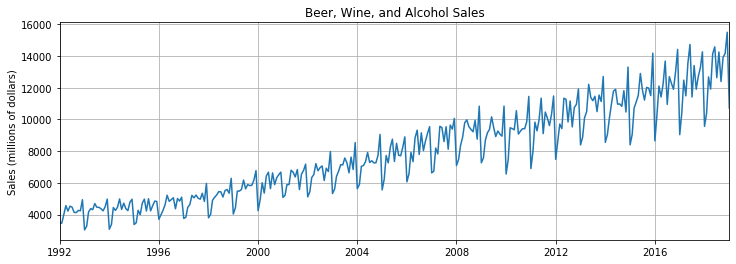

In [6]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [7]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [11]:
train_norm.min()

-1.0

In [12]:
train_norm.max()

1.0

In [13]:
train_norm.mean()

-0.2041940178388313

In [14]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [16]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1, 100).

In [17]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [18]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [20]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310209
Epoch:  2 Loss: 0.37532014
Epoch:  3 Loss: 0.39027178
Epoch:  4 Loss: 0.34934717
Epoch:  5 Loss: 0.33085644
Epoch:  6 Loss: 0.33229983
Epoch:  7 Loss: 0.32670361
Epoch:  8 Loss: 0.32074136
Epoch:  9 Loss: 0.30653542
Epoch: 10 Loss: 0.29518038
Epoch: 11 Loss: 0.26934329
Epoch: 12 Loss: 0.25998515
Epoch: 13 Loss: 0.24665697
Epoch: 14 Loss: 0.22404009
Epoch: 15 Loss: 0.18602613
Epoch: 16 Loss: 0.18561210
Epoch: 17 Loss: 0.17209387
Epoch: 18 Loss: 0.25162542
Epoch: 19 Loss: 0.22557783
Epoch: 20 Loss: 0.17451544
Epoch: 21 Loss: 0.20238443
Epoch: 22 Loss: 0.20811711
Epoch: 23 Loss: 0.16640386
Epoch: 24 Loss: 0.17608391
Epoch: 25 Loss: 0.11974433
Epoch: 26 Loss: 0.09696122
Epoch: 27 Loss: 0.04577365
Epoch: 28 Loss: 0.05801177
Epoch: 29 Loss: 0.00058114
Epoch: 30 Loss: 0.11028978
Epoch: 31 Loss: 0.02632961
Epoch: 32 Loss: 0.03640261
Epoch: 33 Loss: 0.00946236
Epoch: 34 Loss: 0.03581269
Epoch: 35 Loss: 0.05593281
Epoch: 36 Loss: 0.04136664
Epoch: 37 Loss: 0.02676049
E

## Run predictions and compare to known test set

In [21]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.2921541631221771,
 0.6438230872154236,
 0.43504488468170166,
 0.8054205775260925,
 0.9695079326629639,
 0.447756826877594,
 0.8133572340011597,
 0.5087440609931946,
 0.6352367997169495,
 0.7821237444877625,
 0.9953593015670776,
 0.1295965015888214]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10589.45577718],
       [12646.54314867],
       [11425.29505295],
       [13591.80766824],
       [14551.63665211],
       [11499.65355882],
       [13638.23314029],
       [11856.39838478],
       [12596.31765994],
       [13455.53284338],
       [14702.85423452],
       [ 9638.57473604]])

In [24]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [25]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

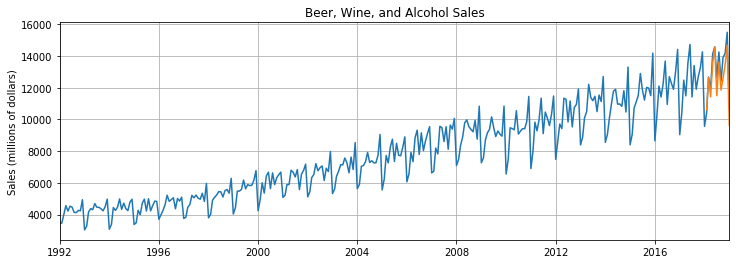

In [26]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

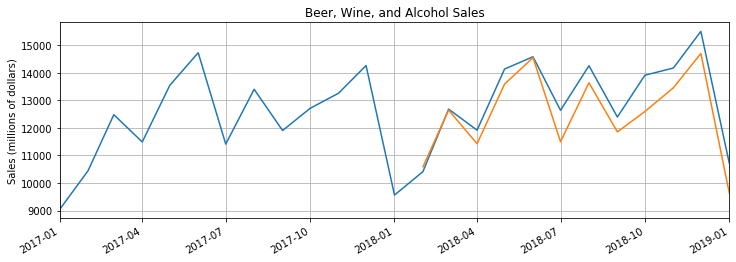

In [27]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>
# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [28]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01519165
Epoch:  2 Loss: 0.01909273
Epoch:  3 Loss: 0.01173244
Epoch:  4 Loss: 0.00965820
Epoch:  5 Loss: 0.00863236
Epoch:  6 Loss: 0.00808806
Epoch:  7 Loss: 0.00700226
Epoch:  8 Loss: 0.00991449
Epoch:  9 Loss: 0.00868521
Epoch: 10 Loss: 0.00520059
Epoch: 11 Loss: 0.00633025
Epoch: 12 Loss: 0.00318221
Epoch: 13 Loss: 0.00262531
Epoch: 14 Loss: 0.00304784
Epoch: 15 Loss: 0.00449646
Epoch: 16 Loss: 0.00335891
Epoch: 17 Loss: 0.00009569
Epoch: 18 Loss: 0.00050731
Epoch: 19 Loss: 0.00402547
Epoch: 20 Loss: 0.00272978
Epoch: 21 Loss: 0.00244804
Epoch: 22 Loss: 0.00024185
Epoch: 23 Loss: 0.00067848
Epoch: 24 Loss: 0.00000619
Epoch: 25 Loss: 0.00001913
Epoch: 26 Loss: 0.00031920
Epoch: 27 Loss: 0.01114018
Epoch: 28 Loss: 0.00699324
Epoch: 29 Loss: 0.00107513
Epoch: 30 Loss: 0.00220884
Epoch: 31 Loss: 0.00326937
Epoch: 32 Loss: 0.00421480
Epoch: 33 Loss: 0.00048408
Epoch: 34 Loss: 0.00070740
Epoch: 35 Loss: 0.00274615
Epoch: 36 Loss: 0.00155991
Epoch: 37 Loss: 0.00150031
E

## Predict future values, plot the result

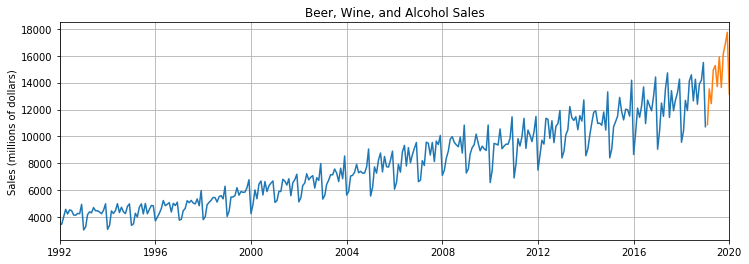

In [29]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12, 4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions[window_size:])
plt.show()

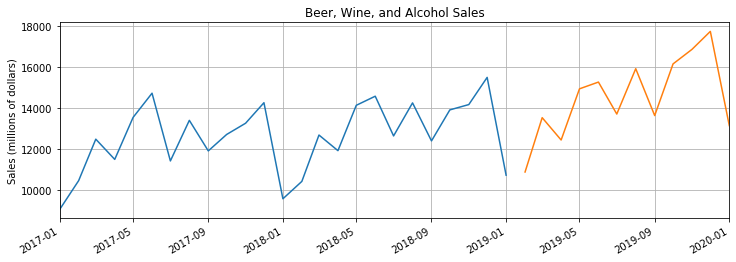

In [30]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()